In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import time
import math
import random
import unicodedata
import re
import os
import json

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, random_split
from collections import Counter
from tqdm.notebook import tqdm

## Data acquisition

In [ ]:

base_path = '/kaggle/input/rekhta-dataset/dataset'
pairs = []

for poet in os.listdir(base_path):
    poet_path = os.path.join(base_path, poet)
    if not os.path.isdir(poet_path):
        continue
    
    en_path = os.path.join(poet_path, 'en')
    ur_path = os.path.join(poet_path, 'ur')
    
    if os.path.exists(en_path) and os.path.exists(ur_path):
        en_files = sorted(os.listdir(en_path))
        ur_files = sorted(os.listdir(ur_path))
        
        for i, (en_file, ur_file) in enumerate(zip(en_files, ur_files)):
            en_full = os.path.join(en_path, en_file)
            ur_full = os.path.join(ur_path, ur_file)
            
            with open(en_full, 'r', encoding='utf-8') as f_en, open(ur_full, 'r', encoding='utf-8') as f_ur:
                roman_text = f_en.read().strip()
                urdu_text = f_ur.read().strip()
            
            if urdu_text and roman_text:  # Skip empty
                pairs.append((urdu_text, roman_text, poet))  # Add poet as third element


df = pd.DataFrame(pairs, columns=['urdu', 'roman', 'poet'])
df.to_csv('/kaggle/working/dataset_extracted.csv', index=False, encoding='utf-8')
print(f"Extracted {len(df)} pairs")
print("done")

In [ ]:
print(df.shape)
print("done")

## Data Cleaning

In [ ]:
# read dataset_extracted
df = pd.read_csv('/kaggle/working/dataset_extracted.csv', encoding='utf-8')

In [ ]:
import unicodedata
import re
import pandas as pd

df = pd.read_csv('/kaggle/working/dataset_extracted.csv', encoding='utf-8')

# Cleaning functions
def clean_urdu(text):
    text = unicodedata.normalize('NFC', text)
    text = re.sub(r'[^\u0600-\u06FF\s\n]', '', text)  # Keep Urdu chars + whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def clean_roman(text):
    text = text.lower()
    text = re.sub(r'[^\w\s\n]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning directly to existing columns
df['urdu'] = df['urdu'].apply(clean_urdu)
df['roman'] = df['roman'].apply(clean_roman)

# Drop rows where either column is empty
df = df[(df['urdu'] != '') & (df['roman'] != '')]

# Save the updated DataFrame
df.to_csv('/kaggle/working/cleaned_pairs.csv', index=False, encoding='utf-8')
print("Cleaned Shape:", df.shape)

# Verify Sample
print("\nUrdu Cleaned:\n", df[['urdu']].head(1).to_string())
print("\nRoman Cleaned:\n", df[['roman']].head(1).to_string())

## Tokenization

In [21]:
# global variables
CLEANED_PAIRS = '/kaggle/input/cleaned/cleaned_pairs.csv'

(1)

In [22]:
# read cleaned data
df = pd.read_csv(CLEANED_PAIRS, encoding='utf-8')
df.head()

,urdu,roman,poet
0,آ گیا پھر رمضاں کیا ہوگا ہائے اے پیر مغاں کیا ...,aa gayā phir ramazāñ kyā hogā haae ai pīremuġh...,nazm-tabatabai
1,آ کے مجھ تک کشتیٔ مے ساقیا الٹی پھری آج کیا ند...,aa ke mujh tak kashtīemai sāqiyā ultī phirī aa...,nazm-tabatabai
2,عبث ہے ناز استغنا پہ کل کی کیا خبر کیا ہو خدا ...,abas hai nāzeistiġhnā pe kal kī kyā ḳhabar kyā...,nazm-tabatabai
3,بدعت مسنون ہو گئی ہے امت مطعون ہو گئی ہے کیا ک...,bidat masnūn ho gaī hai ummat matūn ho gaī hai...,nazm-tabatabai
4,احسان لے نہ ہمت مردانہ چھوڑ کر رستہ بھی چل تو ...,ehsān le na himmatemardāna chhoḍ kar rasta bhī...,nazm-tabatabai


In [23]:
from collections import Counter
import json

def get_char_tokens(text):
    """Tokenize text into characters, replace spaces with '_'"""
    return list(text.replace(' ', '_'))

def get_pair_stats(tokens_list):
    """Count frequency of all symbol pairs."""
    pairs = Counter()
    for tokens in tokens_list:
        for i in range(len(tokens) - 1):
            pairs[(tokens[i], tokens[i+1])] += 1
    return pairs

def merge_pair(tokens, pair, new_token):
    """Merge a specific pair in a sequence."""
    result = []
    i = 0
    while i < len(tokens):
        if i < len(tokens)-1 and (tokens[i], tokens[i+1]) == pair:
            result.append(new_token)
            i += 2
        else:
            result.append(tokens[i])
            i += 1
    return result

def run_bpe(tokens_list, target_vocab_size):
    """Run BPE until vocab reaches target size."""
    vocab = Counter([tok for seq in tokens_list for tok in seq])
    merges = []
    
    while len(vocab) < target_vocab_size:
        pairs = get_pair_stats(tokens_list)
        if not pairs:
            break
        best_pair = max(pairs, key=pairs.get)
        new_token = ''.join(best_pair)
        merges.append((best_pair, new_token))
        
        # Apply merge
        tokens_list = [merge_pair(tokens, best_pair, new_token) for tokens in tokens_list]
        
        # Update vocab
        vocab[new_token] = pairs[best_pair]
    
    return tokens_list, vocab, merges

def tokens_to_indices(tokens_list, vocab):
    """Convert list of tokens to indices. OOV → len(vocab)."""
    return [[vocab.get(token, len(vocab)) for token in tokens] for tokens in tokens_list]

def apply_merges(tokens, merges):
    """Apply saved merges sequentially."""
    for pair, new_token in merges:
        tokens = merge_pair(tokens, tuple(pair), new_token)
    return tokens

def tokenize_inference(text, merges, vocab):
    """Tokenize a new sentence using saved merges + vocab."""
    tokens = get_char_tokens(text)
    tokens = apply_merges(tokens, merges)
    indices = [vocab.get(token, len(vocab)) for token in tokens]
    return tokens, indices

# ======================
# Step 2: Train BPE
# ======================

# Initial char-level tokens
urdu_tokens = [get_char_tokens(text) for text in df['urdu']]
roman_tokens = [get_char_tokens(text) for text in df['roman']]

# Run BPE separately
target_vocab_size = 2500
urdu_tokens, urdu_vocab, urdu_merges = run_bpe(urdu_tokens, target_vocab_size)
roman_tokens, roman_vocab, roman_merges = run_bpe(roman_tokens, target_vocab_size)

# Build vocab maps
urdu_vocab_map = {token: idx for idx, token in enumerate(sorted(urdu_vocab.keys()))}
roman_vocab_map = {token: idx for idx, token in enumerate(sorted(roman_vocab.keys()))}

# Convert to indices
urdu_indices = tokens_to_indices(urdu_tokens, urdu_vocab_map)
roman_indices = tokens_to_indices(roman_tokens, roman_vocab_map)

# one time only
def save_json(data, path):
    with open(path, "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=2)

save_json(urdu_merges, "/kaggle/working/urdu_merges.json")
save_json(roman_merges, "/kaggle/working/roman_merges.json")
save_json(urdu_vocab_map, "/kaggle/working/urdu_vocab.json")
save_json(roman_vocab_map, "/kaggle/working/roman_vocab.json")

df['urdu_tokens'] = [' '.join(tokens) for tokens in urdu_tokens]
df['roman_tokens'] = [' '.join(tokens) for tokens in roman_tokens]
df['urdu_indices'] = urdu_indices
df['roman_indices'] = roman_indices
df.to_csv('/kaggle/working/tokenized_pairs.csv', index=False, encoding='utf-8')

print("Training complete. Tokenized data, vocab, and merges saved.")

✅ Training complete. Tokenized data, vocab, and merges saved.


In [ ]:
print(f"Tokenized {len(df)} pairs with vocabulary size: Urdu={len(urdu_vocab)}, Roman={len(roman_vocab)}")

In [ ]:

new_urdu = "محبت بھرا دل"
new_roman = "mohabbat bhara dil"

urdu_tokens_inf, urdu_indices_inf = tokenize_inference(new_urdu, urdu_merges, urdu_vocab_map)
roman_tokens_inf, roman_indices_inf = tokenize_inference(new_roman, roman_merges, roman_vocab_map)

print("Urdu tokens:", urdu_tokens_inf)
print("Urdu indices:", urdu_indices_inf)
print("Roman tokens:", roman_tokens_inf)
print("Roman indices:", roman_indices_inf)

In [33]:
print(f"Tokenized {len(df)} pairs with vocabulary size {len(urdu_vocab)}")
print(df.columns)

Tokenized 1314 pairs with vocabulary size 2500
Index(['urdu', 'roman', 'poet', 'urdu_tokens', 'roman_tokens', 'urdu_indices',
       'roman_indices'],
      dtype='object')


## Data Preparation

In [19]:
# Global variables
TOKENIZED_PAIRS = '/kaggle/input/ds1234/tokenized_pairs.csv'
# json
URDU_VOCAB = "/kaggle/input/ds1234/urdu_vocab.json"
ROMAN_VOCAB = "/kaggle/input/ds1234/roman_vocab.json"

URDU_MERGES = '/kaggle/input/ds1234/urdu_merges.json'
ROMAN_MERGES = '/kaggle/input/ds1234/roman_merges.json'

In [20]:
# Load the tokenized dataset
df = pd.read_csv(TOKENIZED_PAIRS, encoding='utf-8')

import json

# Paths to your vocab JSON files


# Load urdu vocab
with open(URDU_VOCAB, "r", encoding="utf-8") as f:
    urdu_vocab_map = json.load(f)

# Load roman vocab
with open(ROMAN_VOCAB, "r", encoding="utf-8") as f:
    roman_vocab_map = json.load(f)

with open(URDU_MERGES, "r", encoding="utf-8") as f:
    urdu_merges = json.load(f)

# Load roman vocab
with open(ROMAN_MERGES, "r", encoding="utf-8") as f:
    roman_merges = json.load(f)

# (Optional) If the values need to be integers (indices)
# urdu_vocab_map = {k: int(v) for k, v in urdu_vocab_map.items()}
# roman_vocab_map = {k: int(v) for k, v in roman_vocab_map.items()}


In [6]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"⚡ Using device: {device}")

# Set seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
set_seed(42)

⚡ Using device: cuda


Length Statistics:
          urdu_len    roman_len
count  1314.000000  1314.000000
mean    155.770167   165.982496
std      76.790715    82.719249
min      16.000000    17.000000
25%     104.000000   111.000000
50%     137.000000   146.000000
75%     188.000000   201.000000
max     650.000000   680.000000


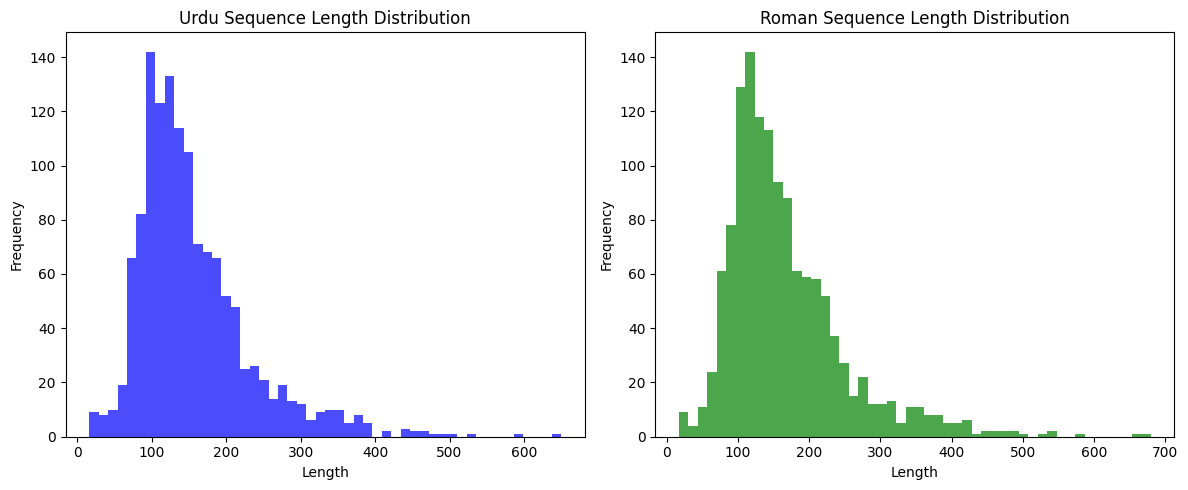

95th percentile for Urdu length: 316.0
95th percentile for Roman length: 342.6999999999998


In [7]:

# Convert string representations of indices back to lists
def parse_indices(indices_str):
    return eval(indices_str) if isinstance(indices_str, str) else indices_str

df['urdu_indices'] = df['urdu_indices'].apply(parse_indices)
df['roman_indices'] = df['roman_indices'].apply(parse_indices)

# Calculate sequence lengths
df['urdu_len'] = df['urdu_indices'].apply(len)
df['roman_len'] = df['roman_indices'].apply(len)

# Statistical summary
print("Length Statistics:")
print(df[['urdu_len', 'roman_len']].describe())

# Visualize distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['urdu_len'], bins=50, color='blue', alpha=0.7)
plt.title('Urdu Sequence Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['roman_len'], bins=50, color='green', alpha=0.7)
plt.title('Roman Sequence Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('/kaggle/working/length_distributions.png')
plt.show()

# Determine 95th percentile
urdu_95th = np.percentile(df['urdu_len'], 95)
roman_95th = np.percentile(df['roman_len'], 95)
print(f"95th percentile for Urdu length: {urdu_95th}")
print(f"95th percentile for Roman length: {roman_95th}")

In [11]:
print(type(df['urdu_indices'].iloc[0]))
print(df['urdu_indices'].iloc[0])


<class 'list'>
[50, 2057, 991, 1700, 331, 2422, 2358, 2266, 347, 2010, 2443, 1614, 1447, 331, 2422, 2358, 374, 713, 503, 1133, 1638, 2422, 2358, 587, 681, 583, 1907, 2274, 2422, 2358, 844, 1981, 2346, 1682, 1797, 1969, 300, 282, 1503, 331, 2422, 2358, 922, 998, 1018, 2386, 1144, 1637, 2376, 445, 2484, 183, 1741, 1571, 2396, 2274, 2422, 2358, 966, 1583, 1050, 2028, 2408, 944, 15, 1682, 901, 644, 1611, 2180, 583, 939, 1918, 2239, 2422, 2358, 2358, 413, 345, 1849, 1761, 566, 1981, 477, 772, 1845, 1002, 2239, 2422, 2358, 2298, 1631, 156, 1713, 1710, 2159, 745, 1856, 2296, 747, 2422, 2358, 1672, 37, 681, 805, 1710, 1786, 2007, 144, 2057, 2471, 535, 386, 3, 1813, 2239, 2422, 2358, 692, 1384, 901, 2341, 2003, 2156, 215, 837, 2096, 218, 1383, 2, 511, 2239, 2422, 2358, 2422, 538, 989, 2386, 2422, 1799, 538, 300, 2057, 1936, 856, 1099, 2422, 2358, 1426, 1261, 372, 1851, 98, 786, 878, 43, 1012, 2357, 981, 1403, 2436, 2422, 2319, 2179]


In [8]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import json

with open(URDU_VOCAB, "r", encoding="utf-8") as f:
    urdu_vocab = json.load(f)
with open(ROMAN_VOCAB, "r", encoding="utf-8") as f:
    roman_vocab = json.load(f)


class UrduRomanDataset(Dataset):
    def __init__(self, df, urdu_vocab, roman_vocab, max_len=350):
        # TODO use eval only first time
        # self.urdu = df['urdu_indices'].apply(eval).tolist()
        # self.roman = df['roman_indices'].apply(eval).tolist()
        self.urdu = df['urdu_indices'].tolist()
        self.roman = df['roman_indices'].tolist()
        self.urdu_vocab = urdu_vocab
        self.roman_vocab = roman_vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.urdu)

    def __getitem__(self, idx):
        src = self.urdu[idx]
        tgt = self.roman[idx]

        # Pad or truncate
        src = src[:self.max_len] + [len(self.urdu_vocab)] * (self.max_len - len(src))
        tgt = tgt[:self.max_len] + [len(self.roman_vocab)] * (self.max_len - len(tgt))

        return torch.tensor(src, dtype=torch.long), torch.tensor(tgt, dtype=torch.long)


MAX_LEN = 350  
BATCH_SIZE = 16

dataset = UrduRomanDataset(df, urdu_vocab, roman_vocab, max_len=MAX_LEN)

train_size = int(0.5 * len(dataset))
val_size = int(0.25 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE)

print("Dataset ready:", len(train_set), "train,", len(val_set), "val,", len(test_set), "test")

Dataset ready: 657 train, 328 val, 329 test


## Model Initialization

### Model Defination

In [9]:
class Encoder(nn.Module):
    def __init__(self, input_size, embed_size, hidden_size, num_layers=2, dropout=0.3):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Embedding layer
        self.embedding = nn.Embedding(input_size, embed_size)
        
        # BiLSTM layers - 2 layers as specified in requirements
        self.lstm = nn.LSTM(
            embed_size,
            hidden_size,
            num_layers=num_layers,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        # Projection layers to convert bidirectional outputs to decoder format
        self.fc_hidden = nn.Linear(hidden_size * 2, hidden_size)
        self.fc_cell = nn.Linear(hidden_size * 2, hidden_size)
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Apply embedding and dropout
        embedded = self.dropout(self.embedding(x))
        
        # Pass through BiLSTM
        outputs, (hidden, cell) = self.lstm(embedded)
        
        # Process final hidden state for decoder initialization
        hidden_forward = hidden[0:self.num_layers]
        hidden_backward = hidden[self.num_layers:]
        cell_forward = cell[0:self.num_layers]
        cell_backward = cell[self.num_layers:]
        
        # Use the last layer hidden state
        last_hidden_forward = hidden_forward[-1]
        last_hidden_backward = hidden_backward[-1]
        last_cell_forward = cell_forward[-1]
        last_cell_backward = cell_backward[-1]
        
        # Concatenate forward and backward last hidden states
        last_hidden = torch.cat([last_hidden_forward, last_hidden_backward], dim=1)
        last_cell = torch.cat([last_cell_forward, last_cell_backward], dim=1)
        
        # Project to decoder dimensions
        dec_hidden = self.fc_hidden(last_hidden)
        dec_cell = self.fc_cell(last_cell)
        
        return outputs, dec_hidden, dec_cell

# LSTM Decoder
class Decoder(nn.Module):
    def __init__(self, output_size, embed_size, hidden_size, num_layers=4, dropout=0.3):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        
        # Embedding layer
        self.embedding = nn.Embedding(output_size, embed_size)
        
        # LSTM layers - 4 layers as specified in requirements
        self.lstm = nn.LSTM(
            embed_size,
            hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        # Output layer
        self.fc_out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):
        # Apply embedding and dropout
        embedded = self.dropout(self.embedding(input))
        
        # Pass through LSTM
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        
        # Generate output
        prediction = self.fc_out(output.squeeze(1))
        
        return prediction, hidden, cell

# Seq2Seq model combining Encoder and Decoder
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, tgt, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        tgt_len = tgt.shape[1]
        tgt_vocab_size = self.decoder.output_size
        
        # Tensor to store decoder outputs
        outputs = torch.zeros(batch_size, tgt_len, tgt_vocab_size).to(self.device)
        
        # Encode the source sequence
        _, hidden, cell = self.encoder(src)
        
        # First decoder input is the <sos> token
        input = tgt[:, 0:1]
        
        # Convert hidden and cell for decoder
        hidden = hidden.unsqueeze(0).repeat(self.decoder.num_layers, 1, 1)
        cell = cell.unsqueeze(0).repeat(self.decoder.num_layers, 1, 1)
        
        for t in range(1, tgt_len):
            # Pass through decoder
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            # Store prediction
            outputs[:, t, :] = output
            
            # Decide whether to use teacher forcing
            teacher_force = random.random() < teacher_forcing_ratio
            
            # Update input: use ground truth or predicted token
            input = tgt[:, t:t+1] if teacher_force else output.argmax(1).unsqueeze(1)
        
        return outputs
    
    def translate(self, src, max_len=100, sos_idx=0, eos_idx=None):
        batch_size = src.shape[0]
        
        # Tensor to store outputs
        outputs = torch.zeros(batch_size, max_len).long().to(self.device)
        outputs[:, 0] = sos_idx
        
        # Track finished sequences if eos_idx provided
        if eos_idx is not None:
            finished_sequences = torch.zeros(batch_size).bool().to(self.device)
        
        # Encode source sequence
        _, hidden, cell = self.encoder(src)
        
        # Prepare for decoder
        hidden = hidden.unsqueeze(0).repeat(self.decoder.num_layers, 1, 1)
        cell = cell.unsqueeze(0).repeat(self.decoder.num_layers, 1, 1)
        input = outputs[:, 0:1]
        
        # Decode step by step
        for t in range(1, max_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            # Store prediction
            top1 = output.argmax(1)
            outputs[:, t] = top1
            
            # Next input is current prediction
            input = top1.unsqueeze(1)
            
            # Check for finished sequences
            if eos_idx is not None:
                finished_sequences = finished_sequences | (top1 == eos_idx)
                if finished_sequences.all():
                    break
        
        return outputs
print("done")

done


## Training

In [10]:
def save_checkpoint(model, optimizer, scheduler, epoch, history, best_val_loss, path):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'epoch': epoch,
        'history': history,
        'best_val_loss': best_val_loss
    }, path)
    print(f"Checkpoint saved at epoch {epoch}")

def load_checkpoint(path, model=None, optimizer=None, scheduler=None):
    if not os.path.exists(path):
        return None
    
    checkpoint = torch.load(path)
    
    if model:
        model.load_state_dict(checkpoint['model_state_dict'])
    
    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    if scheduler and 'scheduler_state_dict' in checkpoint and checkpoint['scheduler_state_dict']:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    
    return checkpoint

In [11]:

def train_epoch(model, train_loader, optimizer, criterion, device, teacher_forcing_ratio=0.5):
    model.train()
    epoch_loss = 0
    
    for src, tgt in tqdm(train_loader, desc="Training"):
        src, tgt = src.to(device), tgt.to(device)
        
        optimizer.zero_grad()
        output = model(src, tgt, teacher_forcing_ratio)
        
        output = output[:, 1:].reshape(-1, output.shape[2])
        tgt = tgt[:, 1:].reshape(-1)
        
        loss = criterion(output, tgt)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
    
    return epoch_loss / len(train_loader)

def evaluate(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
        for src, tgt in tqdm(data_loader, desc="Evaluating"):
            src, tgt = src.to(device), tgt.to(device)
            
            output = model(src, tgt, teacher_forcing_ratio=0)
            
            output = output[:, 1:].reshape(-1, output.shape[2])
            tgt = tgt[:, 1:].reshape(-1)
            
            loss = criterion(output, tgt)
            epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(data_loader)
    perplexity = math.exp(avg_loss)
    
    return avg_loss, perplexity



def train(model, train_loader, val_loader, optimizer, criterion, scheduler=None, 
          device=None, start_epoch=0, num_epochs=20, epochs_per_session=4,
          checkpoint_path='/kaggle/working/checkpoint.pt', 
          best_model_path='/kaggle/working/best_model.pt',
          early_stopping_patience=3, eval_frequency=2):
    
    # Initialize history if starting fresh
    if start_epoch == 0:
        history = {'train_loss': [], 'val_loss': [], 'perplexity': []}
        best_val_loss = float('inf')
    else:
        # Load history from checkpoint
        checkpoint = load_checkpoint(checkpoint_path)
        history = checkpoint['history']
        best_val_loss = checkpoint.get('best_val_loss', float('inf'))
    
    patience_counter = 0
    end_epoch = min(start_epoch + epochs_per_session, num_epochs)
    
    for epoch in range(start_epoch, end_epoch):
        start_time = time.time()
        
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        history['train_loss'].append(train_loss)
        
        # Only evaluate at specified frequency or final epoch
        should_evaluate = (epoch + 1) % eval_frequency == 0 or epoch == end_epoch - 1
        
        if should_evaluate:
            val_loss, perplexity = evaluate(model, val_loader, criterion, device)
            history['val_loss'].append(val_loss)
            history['perplexity'].append(perplexity)
            
            if scheduler:
                scheduler.step(val_loss)
            
            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save({
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'val_loss': val_loss,
                    'perplexity': perplexity,
                }, best_model_path)
                print(f"Best model saved (val_loss: {val_loss:.3f})")
            else:
                patience_counter += 1
            
            # Early stopping check
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping triggered after {epoch + 1} epochs")
                break
        else:
            # Fill history with None when not evaluating
            history['val_loss'].append(None)
            history['perplexity'].append(None)
        
        epoch_mins, epoch_secs = divmod(time.time() - start_time, 60)
        print(f'Epoch: {epoch+1}/{num_epochs} | Time: {epoch_mins}m {epoch_secs:.2f}s')
        print(f'Train Loss: {train_loss:.3f}' + (f' | Val Loss: {val_loss:.3f} | Val PPL: {perplexity:.3f}' if should_evaluate else ''))
    
    # Ensure final evaluation is done if we haven't evaluated in the last epoch
    if not should_evaluate:
        val_loss, perplexity = evaluate(model, val_loader, criterion, device)
        history['val_loss'][-1] = val_loss
        history['perplexity'][-1] = perplexity
    
    # Save checkpoint at end of session
    save_checkpoint(model, optimizer, scheduler, epoch + 1, history, best_val_loss, checkpoint_path)
    
    # Return training info
    return {
        'model': model,
        'history': history,
        'current_epoch': epoch + 1,
        'best_val_loss': best_val_loss,
        'completed': epoch + 1 >= num_epochs
    }
print("done")


done


In [12]:

# Driver function to handle training sessions
def run_training(model, train_loader, val_loader, optimizer, criterion, scheduler=None,
                device=None, num_epochs=20, epochs_per_session=4, 
                checkpoint_path='/kaggle/working/checkpoint.pt',
                best_model_path='/kaggle/working/best_model.pt'):
    
    # Check if we're resuming training
    checkpoint = load_checkpoint(
        checkpoint_path, model=model, optimizer=optimizer, scheduler=scheduler
    )
    
    if checkpoint:
        start_epoch = checkpoint['epoch']
        print(f"Resuming training from epoch {start_epoch}/{num_epochs}")
    else:
        start_epoch = 0
        print("Starting fresh training")
    
    # Run training
    result = train(
        model, train_loader, val_loader, optimizer, criterion, scheduler,
        device, start_epoch, num_epochs, epochs_per_session,
        checkpoint_path, best_model_path
    )
    
    # Print status
    if result['completed']:
        print(f"Training completed ({result['current_epoch']}/{num_epochs} epochs)")
    else:
        remaining = num_epochs - result['current_epoch']
        print(f"Training session completed. {remaining} epochs remaining.")
    
    return result


### Start Training

In [15]:
# Initialize model components
INPUT_SIZE = len(urdu_vocab_map) + 1  # +1 for padding/unknown
OUTPUT_SIZE = len(roman_vocab_map) + 1  # +1 for padding/unknown
EMBED_SIZE = 256
HIDDEN_SIZE = 512
ENC_LAYERS = 2
DEC_LAYERS = 4
DROPOUT = 0.3
LEARNING_RATE = 0.001
NUM_EPOCHS = 20
EPOCHS_PER_SESSION = 15

# Initialize model
encoder = Encoder(
    input_size=INPUT_SIZE,
    embed_size=EMBED_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=ENC_LAYERS,
    dropout=DROPOUT
)

decoder = Decoder(
    output_size=OUTPUT_SIZE,
    embed_size=EMBED_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=DEC_LAYERS,
    dropout=DROPOUT
)

model = Seq2Seq(encoder, decoder, device).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=len(roman_vocab_map))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

# Run a training session
result = run_training(
    model, train_loader, val_loader, optimizer, criterion, scheduler,
    device, NUM_EPOCHS, EPOCHS_PER_SESSION
)



Resuming training from epoch 5/20


Training:   0%|          | 0/42 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 6/20 | Time: 0.0m 48.23s
Train Loss: 7.167 | Val Loss: 7.212 | Val PPL: 1355.347


Training:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 7/20 | Time: 0.0m 42.66s
Train Loss: 7.156


Training:   0%|          | 0/42 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 8/20 | Time: 0.0m 48.03s
Train Loss: 7.150 | Val Loss: 7.223 | Val PPL: 1370.138


Training:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 9/20 | Time: 0.0m 42.71s
Train Loss: 7.139


Training:   0%|          | 0/42 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

Early stopping triggered after 10 epochs
Checkpoint saved at epoch 10
Training session completed. 10 epochs remaining.


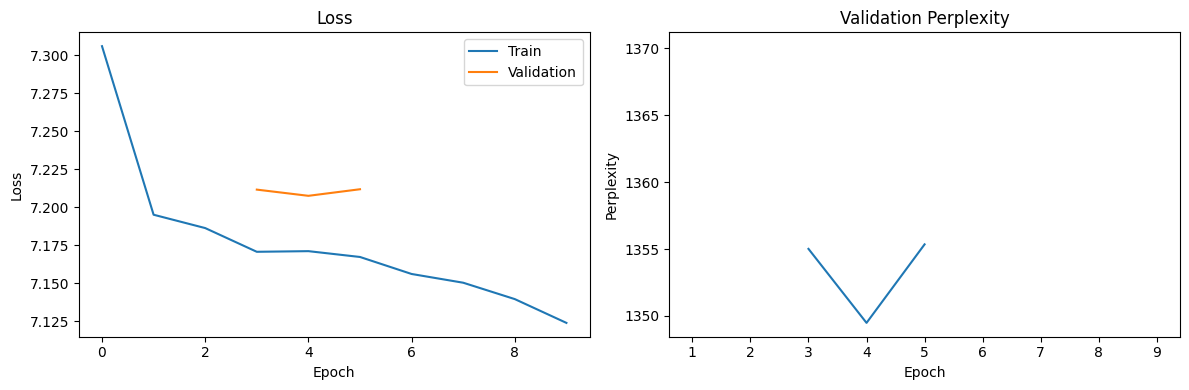

In [16]:
history = result['history']
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history['perplexity'])
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Validation Perplexity')
plt.tight_layout()
plt.show()

## Post Evaluations

In [22]:
def tokenize_inference(text, merges, vocab):
    """Tokenize a new sentence using saved merges + vocab."""
    tokens = list(text.replace(' ', '_'))
    for pair, new_token in merges:
        tokens = merge_pair(tokens, tuple(pair), new_token)
    indices = [vocab.get(token, len(vocab)) for token in tokens]
    return tokens, indices

def merge_pair(tokens, pair, new_token):
    """Merge a specific pair in a sequence."""
    result = []
    i = 0
    while i < len(tokens):
        if i < len(tokens)-1 and (tokens[i], tokens[i+1]) == pair:
            result.append(new_token)
            i += 2
        else:
            result.append(tokens[i])
            i += 1
    return result

In [23]:
# Post-evaluation functions
def calculate_bleu(model, test_loader, roman_vocab_map, device, max_len=100):
    """Calculate BLEU score on the test dataset."""
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
    
    model.eval()
    bleu_scores = []
    smoothing = SmoothingFunction().method1
    
    with torch.no_grad():
        for src, tgt in tqdm(test_loader, desc='Calculating BLEU'):
            src, tgt = src.to(device), tgt.to(device)
            
            # Translate source sequences
            output = model.translate(src, max_len=max_len)
            
            # Process each example in the batch
            for i in range(len(src)):
                # Convert target indices to tokens
                target_seq = []
                for idx in tgt[i].cpu().numpy():
                    if idx >= len(roman_vocab_map):  # Skip padding
                        continue
                    token = next((k for k, v in roman_vocab_map.items() if v == idx), None)
                    if token:
                        target_seq.append(token)
                
                # Convert output indices to tokens
                pred_seq = []
                for idx in output[i, 1:].cpu().numpy():  # Skip <sos>
                    if idx >= len(roman_vocab_map):  # Skip padding
                        continue
                    token = next((k for k, v in roman_vocab_map.items() if v == idx), None)
                    if token:
                        pred_seq.append(token)
                
                # Join tokens and format for BLEU scoring
                target_text = ''.join(target_seq).replace('_', ' ')
                pred_text = ''.join(pred_seq).replace('_', ' ')
                
                # Calculate BLEU score
                bleu = sentence_bleu([target_text.split()], pred_text.split(), smoothing_function=smoothing)
                bleu_scores.append(bleu)
    
    # Return average BLEU score
    return sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0

def calculate_cer(model, test_loader, roman_vocab_map, device, max_len=100):
    """Calculate Character Error Rate on the test dataset."""
    model.eval()
    total_distance = 0
    total_length = 0
    
    # Helper function for edit distance calculation
    def edit_distance(s1, s2):
        """Compute Levenshtein distance between two strings."""
        if len(s1) < len(s2):
            return edit_distance(s2, s1)
        
        if len(s2) == 0:
            return len(s1)
        
        previous_row = range(len(s2) + 1)
        for i, c1 in enumerate(s1):
            current_row = [i + 1]
            for j, c2 in enumerate(s2):
                insertions = previous_row[j + 1] + 1
                deletions = current_row[j] + 1
                substitutions = previous_row[j] + (c1 != c2)
                current_row.append(min(insertions, deletions, substitutions))
            previous_row = current_row
        
        return previous_row[-1]
    
    with torch.no_grad():
        for src, tgt in tqdm(test_loader, desc='Calculating CER'):
            src, tgt = src.to(device), tgt.to(device)
            
            # Translate source sequences
            output = model.translate(src, max_len=max_len)
            
            # Process each example in the batch
            for i in range(len(src)):
                # Convert target indices to tokens
                target_seq = []
                for idx in tgt[i].cpu().numpy():
                    if idx >= len(roman_vocab_map):  # Skip padding
                        continue
                    token = next((k for k, v in roman_vocab_map.items() if v == idx), None)
                    if token:
                        target_seq.append(token)
                
                # Convert output indices to tokens
                pred_seq = []
                for idx in output[i, 1:].cpu().numpy():  # Skip <sos>
                    if idx >= len(roman_vocab_map):  # Skip padding
                        continue
                    token = next((k for k, v in roman_vocab_map.items() if v == idx), None)
                    if token:
                        pred_seq.append(token)
                
                # Join tokens
                target_text = ''.join(target_seq).replace('_', ' ')
                pred_text = ''.join(pred_seq).replace('_', ' ')
                
                # Calculate edit distance
                distance = edit_distance(target_text, pred_text)
                total_distance += distance
                total_length += len(target_text)
    
    # Return average CER
    return total_distance / total_length if total_length > 0 else 1.0

def translate_examples(model, sentences, urdu_merges, urdu_vocab_map, roman_vocab_map, device, max_len=100):
    """Generate translations for example sentences."""
    results = []
    
    for sentence in sentences:
        # Tokenize the input
        tokens, indices = tokenize_inference(sentence, urdu_merges, urdu_vocab_map)
        
        # Convert to tensor
        src_tensor = torch.LongTensor(indices).unsqueeze(0).to(device)
        
        # Translate
        with torch.no_grad():
            output = model.translate(src_tensor, max_len=max_len)
        
        # Convert output indices to text
        translation = []
        for idx in output[0, 1:].cpu().numpy():  # Skip <sos>
            if idx >= len(roman_vocab_map):  # Skip padding
                continue
            token = next((k for k, v in roman_vocab_map.items() if v == idx), None)
            if token:
                translation.append(token)
        
        # Join tokens
        roman_text = ''.join(translation).replace('_', ' ')
        results.append((sentence, roman_text))
    
    return results

# Post-evaluation script
def evaluate_model(model, test_loader, criterion, device, roman_vocab_map, 
                   urdu_merges, urdu_vocab_map, example_sentences=None):
    """Run comprehensive model evaluation."""
    # Load the last saved model
    checkpoint_path = '/kaggle/working/checkpoint.pt'
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded model from checkpoint (epoch {checkpoint['epoch']})")
    
    # Calculate test loss and perplexity
    test_loss, test_perplexity = evaluate(model, test_loader, criterion, device)
    print(f"\nTest Evaluation Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Perplexity: {test_perplexity:.4f}")
    
    # Calculate BLEU score
    bleu_score = calculate_bleu(model, test_loader, roman_vocab_map, device)
    print(f"BLEU Score: {bleu_score:.4f}")
    
    # Calculate Character Error Rate
    cer = calculate_cer(model, test_loader, roman_vocab_map, device)
    print(f"Character Error Rate: {cer:.4f}")
    
    # Generate example translations if provided
    if example_sentences:
        print("\nQualitative Examples:")
        print("-" * 60)
        translations = translate_examples(
            model, example_sentences, urdu_merges, urdu_vocab_map, roman_vocab_map, device
        )
        
        for src, tgt in translations:
            print(f"Urdu:        {src}")
            print(f"Roman Urdu:  {tgt}")
            print("-" * 60)
    
    # Return evaluation metrics
    return {
        "test_loss": test_loss,
        "test_perplexity": test_perplexity,
        "bleu_score": bleu_score,
        "character_error_rate": cer
    }

# Example usage
example_sentences = [
    "محبت بھرا دل",
    "اردو زبان بہت خوبصورت ہے",
    "کیا آپ مجھے سمجھ سکتے ہیں؟"
]

metrics = evaluate_model(
    model, 
    test_loader, 
    criterion, 
    device, 
    roman_vocab_map,
    urdu_merges,
    urdu_vocab_map,
    example_sentences
)

# Save metrics to file
with open('/kaggle/working/evaluation_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)


Loaded model from checkpoint (epoch 10)


Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]


Test Evaluation Results:
Test Loss: 7.2200
Test Perplexity: 1366.4312


Calculating BLEU:   0%|          | 0/21 [00:00<?, ?it/s]

BLEU Score: 0.0024


Calculating CER:   0%|          | 0/21 [00:00<?, ?it/s]

Character Error Rate: 0.7257

Qualitative Examples:
------------------------------------------------------------
Urdu:        محبت بھرا دل
Roman Urdu:  se se se se nahīñ nahīñ nahīñ nahīñ nahīñ nahīñ nahīñ nahīñ hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai 
------------------------------------------------------------
Urdu:        اردو زبان بہت خوبصورت ہے
Roman Urdu:  hai ki t hai se hai nahīñ nahīñ nahīñ nahīñ nahīñ nahīñ hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai hai